In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline
my_year_month_fmt = mdates.DateFormatter('%m/%y')

## Prepare data

In [4]:
data = pd.read_pickle("./data/yahoo.pkl")
data.axes

[Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object'),
 DatetimeIndex(['2016-12-30', '2016-12-29', '2016-12-28', '2016-12-27',
                '2016-12-23', '2016-12-22', '2016-12-21', '2016-12-20',
                '2016-12-19', '2016-12-16',
                ...
                '2010-01-13', '2010-01-12', '2010-01-11', '2010-01-08',
                '2010-01-07', '2010-01-06', '2010-01-05', '2010-01-04',
                '2009-12-31', '2009-12-30'],
               dtype='datetime64[ns]', name='Date', length=1764, freq=None),
 Index(['AAPL', 'F', 'MSFT', '^GSPC'], dtype='object')]

In [12]:
start_date = data.axes[1][-1]
end_date = data.axes[1][0]
weekdays = pd.date_range(start = start_date, end = end_date, freq = 'B')

close = data['Close']
close = close.reindex(weekdays)
close = close.fillna(method="ffill")
close.head()

AAPL       30.234285
F           9.990000
MSFT       30.959999
^GSPC    1126.420044
Name: 2009-12-30 00:00:00, dtype: float64

## Moving average considerations

One of the oldest and simplest trading strategies that exist is the one that uses a moving average of the price (or returns) timeseries to proxy the recent trend of the price.

The idea is quite simple, yet powerful; if we use a (say) 100-day moving average of our price time-series, then a significant portion of the daily price noise will have been “averaged-out”. Thus, we can can observe more closely the longer-term behaviour of the asset.

Let us, again, calculate the rolling simple moving averages (SMA) of these three timeseries as follows. Remember, again, that when calculating the $M$ days SMA, the first $M−1$ are not valid, as $M$ prices are required for the first moving average data point.

In [10]:
moving_average = close.rolling(window=100).mean()
moving_average.head(), moving_average.tail()

(            AAPL   F  MSFT  ^GSPC
 2009-12-30   NaN NaN   NaN    NaN
 2009-12-31   NaN NaN   NaN    NaN
 2010-01-01   NaN NaN   NaN    NaN
 2010-01-04   NaN NaN   NaN    NaN
 2010-01-05   NaN NaN   NaN    NaN,
                 AAPL        F     MSFT        ^GSPC
 2016-12-26  111.7931  12.2017  59.0630  2176.628791
 2016-12-27  111.8776  12.2025  59.1138  2177.500190
 2016-12-28  111.9652  12.2025  59.1635  2178.244490
 2016-12-29  112.0532  12.2017  59.2095  2178.879189
 2016-12-30  112.1296  12.1997  59.2515  2179.426990)

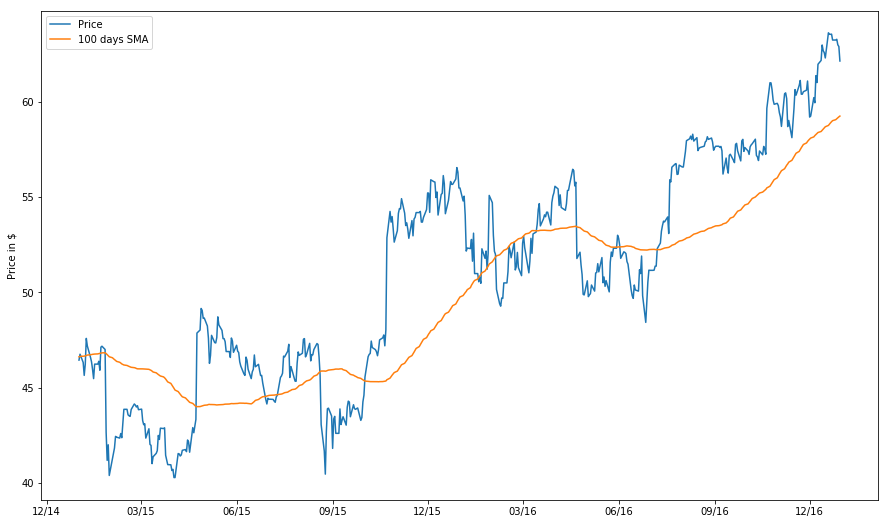

In [13]:
plot_start = '2015-01-01'
plot_end = '2016-12-31'

fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(close.loc[plot_start:plot_end].index, close.loc[plot_start:plot_end, 'MSFT'], label='Price')
ax.plot(moving_average.loc[plot_start:plot_end].index, moving_average.loc[plot_start:plot_end, 'MSFT'], label='100 days SMA')
ax.set_ylabel("Price in $")
ax.legend(loc='best')
ax.xaxis.set_major_formatter(my_year_month_fmt)

plt.show()

It is straightforward to observe that SMA timeseries are much less noisy than the original price timeseries. However, this comes at a cost: SMA timeseries lag the original price timeseries, which means that changes in the trend are only seen with a delay (lag) of $L$ days.

How much is this lag $L$? For a SMA moving average calculated using $M$ days, the lag is roughly $\frac{M}{2}$ days. Thus, if we are using a 100 days SMA, this means we may be late by almost 50 days, which can significantly affect our strategy.

One way to reduce the lag induced by the use of the SMA is to use the so-called Exponential Moving Average (EMA), defined as
$$EMA(t)=(1−\alpha)EMA(t−1)+ \alpha p(t)$$
$$EMA(t_0) = p(t_0)$$
where $p(t)$ is the price at time $t$ and $\alpha$ is called the decay parameter for the EMA. $\alpha$ is related to the lag as
$$\alpha = \frac{1}{L + 1}$$
and the length of the window (span) $M$ as
$$\alpha = \frac{2}{M + 1}$$

The reason why EMA reduces the lag is that it puts more weight on more recent observations, whereas the SMA weights all observations equally by $\frac{1}{M}$. We should check the documentation of DataFrame's `ewm` method to understand more details and variants of EMA. For example, by simple calculation, we see that the sum of weights are not equal to 1, is this a problem?

In [25]:
# 'span' specifies M which is used to calculate \alpha as above. 'adjust' = False means 
# we calculate ema in a recursice way like above, instead of another EMA variant ('adjust' = True) where we 
# simply have exponentially decayed weights w_i = (1-\alpha)^i for p(t - i)
ema = close.ewm(span = 100, adjust = False)
print(type(ema))
ema = ema.mean()
ema.head()

<class 'pandas.core.window.EWM'>


,AAPL,F,MSFT,^GSPC
2009-12-30,30.234285,9.990000,30.959999,1126.420044
2009-12-31,30.231711,9.990198,30.950494,1126.195884
2010-01-01,30.229187,9.990392,30.941177,1125.976163
2010-01-04,30.235993,9.996127,30.941352,1126.115051
2010-01-05,30.243710,10.015214,30.941721,1126.321090


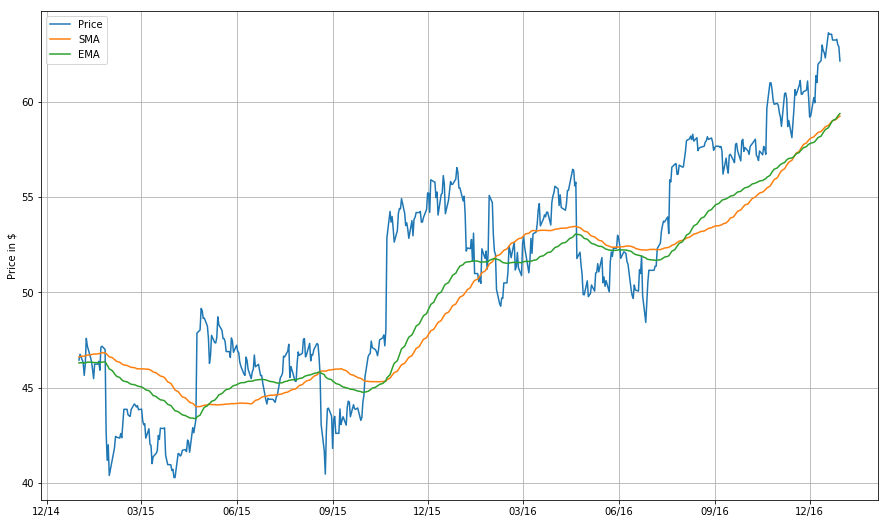

In [26]:
fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(1, 1, 1)
ax.plot(close.loc[plot_start:plot_end].index, close.loc[plot_start:plot_end, 'MSFT'], label = "Price")
ax.plot(moving_average.loc[plot_start:plot_end].index, moving_average.loc[plot_start:plot_end, 'MSFT'], label = "SMA")
ax.plot(ema.loc[plot_start:plot_end].index, ema.loc[plot_start:plot_end, 'MSFT'], label = "EMA")

ax.set_ylabel("Price in $")
ax.legend(loc='best')
ax.grid()
ax.xaxis.set_major_formatter(my_year_month_fmt)

plt.show()

Well, does it help a lot? Hehe...

## A moving average trading strategy

Let us attempt to use the moving averages calculated above to design a trading strategy. Our first attempt is going to be relatively straghtforward and is going to take advantage of the fact that a moving average timeseries (whether SMA or EMA) lags the actual price behaviour.

Bearing this in mind, it is natural to assume that when a change in the long term behaviour of the asset occurs, the actual price timeseries will react faster than the EMA one. Therefore, we will consider the crossing of the two as potential trading signals.

1. When the price timeseries $p(t)$ crosses the EMA timeseries $e(t)$ from below, we will close any existing short position and go long (buy) one unit of the asset.
2. When the price timeseries $p(t)$ crosses the EMA timeseries $e(t)$ from above, we will close any existing long position and go short (sell) one unit of the asset.

<img src="img/Moving-Average-Price-Crossover-Illustration.png">

How is this translated to the framework described in our previous article about the weights $w(t)$?

Well for this strategy it is pretty straghtforward. All we need is to have a long position, i.e. $w_i(t) >0$, as long as the price timeseries is above the EMA timeseries and a short position, i.e. $w_i(t) < 0$, as long as the price timeseries is below the EMA timeseries.

Since, at this point, we are not interested yet in position sizing, we will assume that we use all our funds available to trade asset $i$. We will also assume that our funds are split equally across all $4$ assets (MSFT, AAPL and ^GSPC).

Based on these assumptions, our strategy for each of the assets $i,i=1,\cdots,4$ can be translated as follows:
- Go long condition: If $p_i(t)>e_i(t)$, then $w_i(t)=\frac{1}{4}$
- Go short condition: If $p_i(t)<e_i(t)$, then $w_i(t)=−\frac{1}{4}$

How is this implemented in Python? The trick is to take the sign of the difference between then price $p_i(t)$ and the EMA $e_i(t)$.

In [27]:
trading_positions_raw = close - ema
trading_positions_raw.head()

,AAPL,F,MSFT,^GSPC
2009-12-30,0.000000,0.000000,0.000000,0.000000
2009-12-31,-0.127425,0.009802,-0.470494,-11.095908
2010-01-01,-0.124901,0.009608,-0.461177,-10.876187
2010-01-04,0.336864,0.283873,0.008649,6.874939
2010-01-05,0.382003,0.944786,0.018278,10.198930


In [29]:
trading_positions = trading_positions_raw.apply(np.sign) * 1 / 4
trading_positions.head()

,AAPL,F,MSFT,^GSPC
2009-12-30,0.00,0.00,0.00,0.00
2009-12-31,-0.25,0.25,-0.25,-0.25
2010-01-01,-0.25,0.25,-0.25,-0.25
2010-01-04,0.25,0.25,0.25,0.25
2010-01-05,0.25,0.25,0.25,0.25


## One final caveat

Before seeing the performance of this strategy, let us focus on the first day $t_0$ when the price timeseries $p_i(t_0)$ crosses above and EMA timeseries $e_i(t_0)$. Since $p_i(t_0)>e_i(t_0)$. At that point the trading weight $w_i(t_0)$ becomes positive, and thus according to our trading strategy, we need to set for that day $w_i(t_0)=\frac{1}{4}$.

However, bear in mind that $p_i(t_0)$ is the price of the asset at the close of day $t_0$. For this reason, we will not know that $p_i(t_0)>e_i(t_0)$ until the close of the trading day. Therefore, when calculating the returns of the strategy, to assume that on day $t_0$ we had a long position is an **_error_**; it is equivalent to us peaking into the future, since we only know we have to go long at the end of day $t_0$.

The best we can do is assume that we traded at the close of this day $t_0$. Therefore our position will be long starting on the following day, $t_0+1$. This is easily corrected for by lagging our trading positions by one day, so that on day toto our actual position is that of the previous day $t_0–1$ and only on day $t_0+1$ do we have a long position. Thus:

In [30]:
trading_positions = trading_positions.shift(1)
trading_positions.head()

,AAPL,F,MSFT,^GSPC
2009-12-30,NaN,NaN,NaN,NaN
2009-12-31,0.00,0.00,0.00,0.00
2010-01-01,-0.25,0.25,-0.25,-0.25
2010-01-04,-0.25,0.25,-0.25,-0.25
2010-01-05,0.25,0.25,0.25,0.25


Now that the position our strategy dictates each day has been calculated, the performance of this strategy can be easily estimated. To that end, we will need again the log-returns of the three assets $r_i(t)$. These are calculated as:

In [31]:
log_returns = np.log(close).diff()
log_returns.head()

,AAPL,F,MSFT,^GSPC
2009-12-30,NaN,NaN,NaN,NaN
2009-12-31,-0.004309,0.001001,-0.015625,-0.010100
2010-01-01,0.000000,0.000000,0.000000,0.000000
2010-01-04,0.015445,0.027615,0.015302,0.015916
2010-01-05,0.001727,0.064052,0.000323,0.003111


Note that our strategy trades each asset separately and is agnostic of what the behaviour of the other assets is. Whether we are going to be long or short (and how much) in MSFT is in no way affected by the other two assets. With this in mind, the daily log-returns of the strategy for each asset $i$, $r^s_i(t)$ are calculated as
$$r^s_i(t) = w_i(t)r_i(t)$$
where $w_i(t)$ is the strategy position on day $t$ which has already been attained at the end of trading day $t−1$.

To further explain, suppose $p_i(t-1)$ crosses above $e_i(t-1)$. Before that, we have $p_i(t-2) < e_i(t-2)$. Therefore, at the end of day $t-1$, we know that we should go long, and this thought is reflected by setting $w_i(t) = \frac{1}{4}$ on the next day $t$, but we still have $w_i(t-1) = -\frac{1}{4}$ on day $t-1$. 

Therefore, on day $t$, the daily log-return is $\frac{1}{4}\log(\frac{p_i(t)}{p_i(t-1)})$, hoping $p_i(t)$ is bigger than $p_i(t-1)$, which means the "go long" signal indeed looks like a long term behavior (the stock keeps increasing) but not a noise, otherwise ($p_i(t) < p_i(t-1)$) we are screwed and have a negative return.

Looking at day $t-1$, the log-return is $-\frac{1}{4}\log(\frac{p_i(t-1)}{p_i(t-2)})$, which is very likely to be negative because the "crossing above" behavior means $p_i(t-1)$ is bigger than previous value. **This is the negative effect of the "lagging" behavior of a moving average strategy.**

Finally, looking at day $t-2$, assuming no "crossing", then log-return is $-\frac{1}{4}\log(\frac{p_i(t-2)}{p_i(t-3)})$, which is likely to be positive because the stock keeps decreasing before day $t-1$. This shows a scenario of how negative weight can give positive return: we borrowed and sold the stock, and the stock keeps decreasing, giving us a chance to buy it back at a lower price.

In [32]:
strategy_log_returns = trading_positions * log_returns
strategy_log_returns.head()

,AAPL,F,MSFT,^GSPC
2009-12-30,NaN,NaN,NaN,NaN
2009-12-31,-0.000000,0.000000,-0.000000,-0.000000
2010-01-01,-0.000000,0.000000,-0.000000,-0.000000
2010-01-04,-0.003861,0.006904,-0.003826,-0.003979
2010-01-05,0.000432,0.016013,0.000081,0.000778


## Visualization

Let us examine what the timeseries and the respective trading position look like for one of our assets, Microsoft.

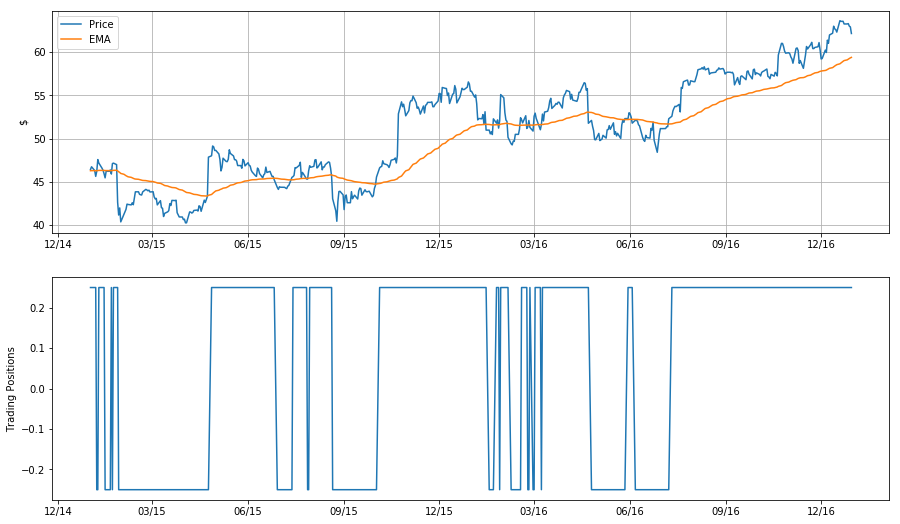

In [37]:
fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(2, 1, 1)
ax.plot(close.loc[plot_start:plot_end].index, close.loc[plot_start:plot_end, 'MSFT'], label = "Price")
ax.plot(ema.loc[plot_start:plot_end].index, ema.loc[plot_start:plot_end, 'MSFT'], label = "EMA")
ax.grid()
ax.set_ylabel("$")
ax.xaxis.set_major_formatter(my_year_month_fmt)
ax.legend(loc='best')

ax = fig.add_subplot(2, 1, 2)
ax.plot(trading_positions.loc[plot_start:plot_end].index, trading_positions.loc[plot_start:plot_end, 'MSFT'])
ax.set_ylabel("Trading Positions")
ax.xaxis.set_major_formatter(my_year_month_fmt)

plt.show()

Remembering that the log-returns can be added to show performance across time, let us plot the cumulative log-returns and the cumulative total relative returns of our strategy for each of the assets.


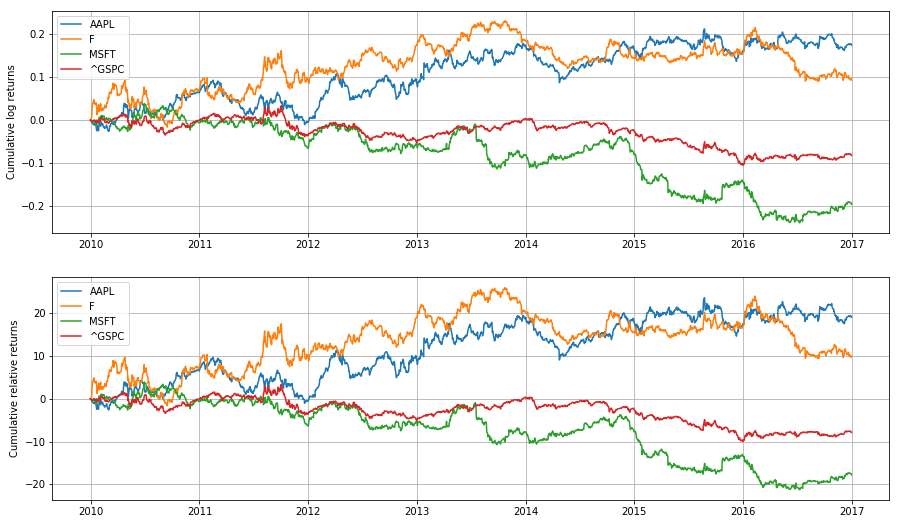

In [41]:
cum_strategy_log_returns = strategy_log_returns.cumsum()
cum_strategy_relative_returns = np.exp(cum_strategy_log_returns) - 1

fig = plt.figure(figsize = (15, 9))
ax = fig.add_subplot(2, 1, 1)

for c in cum_strategy_log_returns:
    ax.plot(cum_strategy_log_returns.index, cum_strategy_log_returns[c], label = c)
ax.set_ylabel("Cumulative log returns")
ax.grid()
ax.legend(loc='best')

ax = fig.add_subplot(2, 1, 2)
for c in cum_strategy_relative_returns:
    ax.plot(cum_strategy_relative_returns.index, 100*cum_strategy_relative_returns[c], label = c)
ax.set_ylabel("Cumulative relative returns")
ax.grid()
ax.legend(loc='best')

plt.show()

## What is the total portfolio return of the strategy?

Strictly speaking, we can only add relative returns to calculate the strategy returns. Therefore
$$r^s_{rel}(t)=\sum_{i=1}^4 r^s_{rel,i}(t)$$

We saw in the previous article, however, that for small values of the relative returns, the following approximation holds
$$r_i(t) \simeq r_{rel, i}(t)$$

Thus, an alternative way is to simply add all the strategy log-returns first and then convert these to relative returns. Let us examine how good this approximation is.

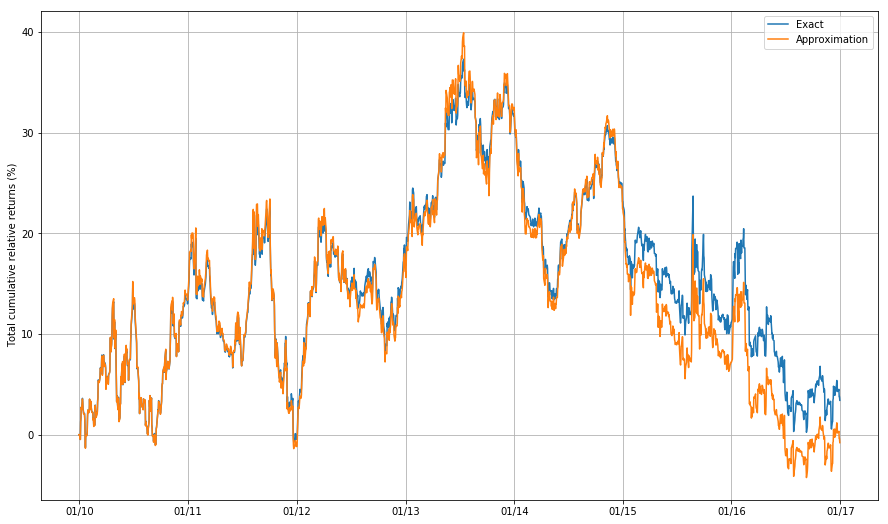

In [39]:
# Total strategy relative returns. This is the exact calculation.
cum_relative_return_exact = cum_strategy_relative_returns.sum(axis=1)

# Get the cumulative log-returns per asset
cum_strategy_log_return = cum_strategy_log_returns.sum(axis=1)

# Transform the cumulative log returns to relative returns. This is the approximation
cum_relative_return_approx = np.exp(cum_strategy_log_return) - 1

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='Exact')
ax.plot(cum_relative_return_approx.index, 100*cum_relative_return_approx, label='Approximation')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.grid()
ax.xaxis.set_major_formatter(my_year_month_fmt)

plt.show()

As we can see, for relatively small time-intervals and as long the assumption that relative returns are small enough, the calculation of the total strategy returns using the log-return approximation can be satisfactory. However, when the small scale assumption breaks down, then the approximation is poor. Therefore what we need to remember the following:

1. Log-returns can and should be added across time for a single asset to calculate cumulative return timeseries across time.
2. However, when summing (or averaging) log-returns across assets, care should be taken. Relative returns can be added, but log-returns only if we can safely assume they are a good-enough approximation of the relative returns.

The overall, yearly, performance of our strategy can be calculated again as:

In [40]:
def print_portfolio_yearly_statistics(portfolio_cumulative_relative_returns, days_per_year = 52 * 5):

    total_days_in_simulation = portfolio_cumulative_relative_returns.shape[0]
    number_of_years = total_days_in_simulation / days_per_year

    # The last data point will give us the total portfolio return
    total_portfolio_return = portfolio_cumulative_relative_returns[-1]
    # Average portfolio return assuming compunding of returns
    average_yearly_return = (1 + total_portfolio_return)**(1/number_of_years) - 1

    print('Total portfolio return is: ' + '{:5.2f}'.format(100*total_portfolio_return) + '%')
    print('Average yearly return is: ' + '{:5.2f}'.format(100*average_yearly_return) + '%')

print_portfolio_yearly_statistics(cum_relative_return_exact)

Total portfolio return is:  3.41%
Average yearly return is:  0.48%


## Strategy Comparison

One can observe that this strategy signficantly underperforms the buy and hold strategy that was presented in the previous article. Let's compare them again:


Total portfolio return is: 115.02%
Average yearly return is: 11.50%


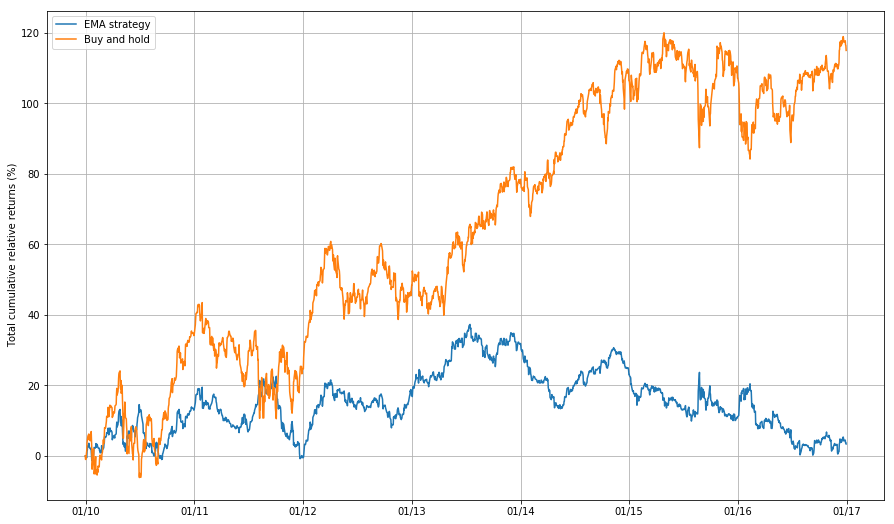

In [43]:
# Define the weights matrix for the simple buy-and-hold strategy
simple_weights_matrix = pd.DataFrame(1/3, index = close.index, columns=close.columns)

# Get the buy-and-hold strategy log returns per asset
simple_strategy_asset_log_returns = simple_weights_matrix * log_returns

# Get the cumulative log-returns per asset
simple_cum_strategy_asset_log_returns = simple_strategy_asset_log_returns.cumsum()

# Transform the cumulative log returns to relative returns
simple_cum_strategy_asset_relative_returns = np.exp(simple_cum_strategy_asset_log_returns) - 1

# Total strategy relative returns. This is the exact calculation.
simple_cum_relative_return_exact = simple_cum_strategy_asset_relative_returns.sum(axis=1)

fig = plt.figure(figsize=(15,9))
ax = fig.add_subplot(1,1,1)

ax.plot(cum_relative_return_exact.index, 100*cum_relative_return_exact, label='EMA strategy')
ax.plot(simple_cum_relative_return_exact.index, 100*simple_cum_relative_return_exact, label='Buy and hold')

ax.set_ylabel('Total cumulative relative returns (%)')
ax.legend(loc='best')
ax.grid()
ax.xaxis.set_major_formatter(my_year_month_fmt)

print_portfolio_yearly_statistics(simple_cum_relative_return_exact)


Which Strategy is Better?
This is not a simple question for one to answer at this point. When we need to choose between two or more strategies, we need to define a metric (or metrics) based on which to compare them.

In addition, we observe in this last graph that the performance of the two strategies is not constant across time. There are some periods when one outperforms the other and other periods when it is not. So a second question that naturally arises is how do we mitigate the risk to be “tricked” by a good backtesting performance in a given period.